# Sentiment analysis

This notebook is used to predict the sentiment of financial texts.
The function definitions are intertwined with the code execution. This makes the code easier to understand.

However, if we were to write a python script (.py), we would first define all the functions and orchestrate their execution at the very end via the main function according to clean-code principles.


In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Type

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import History
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import warnings

warnings.filterwarnings("ignore")

In [3]:
def read_data() -> (pd.DataFrame, pd.DataFrame):
    """
    Reads the data.
    :return: dataframes with raw and post-embedding data
    """
    path_raw = "data/FinancialNewsPreprocessed.csv"
    path_spacy = "data/FinancialNewsSpacyWordEmbeddings.csv"
    path_word2vec = "data/FinancialNewsWord2VecWordEmbeddings.csv"
    data_raw = pd.read_csv(path_raw)
    data_vectors = pd.read_csv(path_spacy, index_col=0)

    return data_raw, data_vectors

In [4]:
data_raw, data_vectors = read_data()

## 1. Preparing the data

#### How does the data look like?

#### Preprocessed (raw) data

In [5]:
data_raw.head(5)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


#### Post-processed vectorized data after word embedding

In [6]:
data_vectors.head(5)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,Sentence,PreprocessedSentence,Sentiment
0,0.133433,0.871901,0.365697,-0.256001,0.373527,-0.271523,0.000461,0.092298,-0.195847,0.058545,...,-0.355532,-0.095407,-0.211593,0.411392,0.543314,-0.259041,-0.269539,The GeoSolutions technology will leverage Bene...,geosolution technology leverage benefon gps so...,positive
1,0.512263,-0.024583,-0.273538,-0.326263,0.391909,-0.244203,-0.302843,-0.198969,0.196050,-0.088305,...,0.254506,0.201047,0.574924,-0.229513,0.403106,0.615872,0.149026,"$ESI on lows, down $1.50 to $2.50 BK a real po...",esi low down to bk real possibility,negative
2,0.048958,0.379891,-0.046013,0.446819,0.181975,-0.155599,-0.232785,-0.095827,0.312827,-0.127036,...,0.052061,0.017183,0.392866,0.052592,0.118632,0.117212,0.192037,"For the last quarter of 2010 , Componenta 's n...",for last quarter of componenta net sale double...,positive
3,0.060623,0.530929,-0.070979,-0.148892,0.331757,-0.179980,-0.083385,-0.172724,0.183011,-0.064152,...,0.141741,-0.178245,0.095900,0.129976,0.214867,-0.168137,0.446573,According to the Finnish-Russian Chamber of Co...,accord to finnishrussian chamber of commerce a...,neutral
4,0.414564,0.390580,0.319709,-0.144357,0.371756,-0.005248,-0.189107,0.019231,-0.186268,-0.280523,...,0.206065,-0.285921,0.233735,0.507143,0.403567,-0.067975,0.082859,The Swedish buyout firm has sold its remaining...,swedish buyout firm have sell its remain perce...,neutral


### 1.1. Replacing sentiment words by numbers

- negative = 0
- neutral = 1
- positive = 2

In [7]:
def map_sentiment(data: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces word "negative" by 0, "neutral" by 1 and "positive" by 2
    (more intuitive would be "negative" by -1, "neutral" by 0 and "positive" by 1,
    but it would cause a problem in neural network model).
    :data: input dataframe
    :return: dataframe with column "Sentiment" transformed from text to integer
    """
    data["Sentiment"] = data["Sentiment"].map(
        {
            "negative": 0,
            "neutral": 1,
            "positive": 2,
        }
    )
    data["Sentiment"] = data["Sentiment"].astype(int)

    return data

In [8]:
def replace_sentiment_by_number(
    data_raw: pd.DataFrame, data_vectors: pd.DataFrame
) -> (pd.DataFrame, pd.DataFrame):
    """
    Replaces words: "negative" by 0, "neutral" by 1 and "positive" by 2.

    :data_raw: dataframe with raw data
    :data_vectors: dataframe with post-embedding data
    :return: dataframes with raw and post-embedding data with sentiment as a number
    """
    data_raw = map_sentiment(data_raw)
    data_vectors = map_sentiment(data_vectors)

    return data_raw, data_vectors

In [9]:
data_raw, data_vectors = replace_sentiment_by_number(data_raw, data_vectors)

### 1.2. Removing "Sentence" and "PreprocessedSentence" columns from post-processed data

In [10]:
data_vectors = data_vectors.drop(["Sentence", "PreprocessedSentence"], axis=1)

#### How does the data look like now?

#### Preprocessed (raw) data

In [11]:
data_raw.head(5)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1


#### Post-processed vectorized data after word embedding

In [12]:
data_vectors.head(5)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,Sentiment
0,0.133433,0.871901,0.365697,-0.256001,0.373527,-0.271523,0.000461,0.092298,-0.195847,0.058545,...,-0.842028,-0.294709,-0.355532,-0.095407,-0.211593,0.411392,0.543314,-0.259041,-0.269539,2
1,0.512263,-0.024583,-0.273538,-0.326263,0.391909,-0.244203,-0.302843,-0.198969,0.196050,-0.088305,...,-0.493122,-0.276705,0.254506,0.201047,0.574924,-0.229513,0.403106,0.615872,0.149026,0
2,0.048958,0.379891,-0.046013,0.446819,0.181975,-0.155599,-0.232785,-0.095827,0.312827,-0.127036,...,-0.368473,0.113239,0.052061,0.017183,0.392866,0.052592,0.118632,0.117212,0.192037,2
3,0.060623,0.530929,-0.070979,-0.148892,0.331757,-0.179980,-0.083385,-0.172724,0.183011,-0.064152,...,-0.461033,-0.209898,0.141741,-0.178245,0.095900,0.129976,0.214867,-0.168137,0.446573,1
4,0.414564,0.390580,0.319709,-0.144357,0.371756,-0.005248,-0.189107,0.019231,-0.186268,-0.280523,...,-0.131717,-0.321930,0.206065,-0.285921,0.233735,0.507143,0.403567,-0.067975,0.082859,1


## 2.  Original sentiment vs sentiment "predicted" by Textblob

We will see our datasets and try to get some informations about them:
- What are the common words used in negative/neutral/positive texts?
- How does the class distributions look like?
- Can we "guess" the sentiment by polarity of words calclulated by TextBlob?
- How many of the negative/neutral/positive texts are in the data?

### 2.1. Original sentiment in preprocessed data

- What are the most common words that appear in negative/neutral/positive texts? 
- Class distribution in raw data
- How many texts are negative/neutral/positive?

In [13]:
def split_sentiment(data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    """
    Splits sentiment into negative, neutral and positive.
    :data: input dataframe
    :return: three dataframes with negative, neutral and positive sentiment
    """
    data_negative = data[data["Sentiment"] == 0]
    data_neutral = data[data["Sentiment"] == 1]
    data_positive = data[data["Sentiment"] == 2]

    return data_negative, data_neutral, data_positive

In [14]:
def visualize_wordcloud(data: pd.DataFrame, all_words: list, bgcolor: str) -> plt:
    """
    Visualizes negative, neutral and positive by WordCloud.
    :data: input dataframe
    :all_words: list of words
    :bgcolor: background color
    :return: plot with common words
    """
    wordcloud = WordCloud(
        width=1000, height=600, background_color="skyblue", min_font_size=15
    ).generate(all_words)
    plt.figure(figsize=(6, 4), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    return plt

In [15]:
def vizualize_words_in_classes(data_raw: pd.DataFrame) -> (plt, plt, plt):
    """
    Vizualizes words in classes for raw data by WordClaud.
    :data_raw: dataframe with raw data
    :return: plots of words occuring in negative, neutral and positive texts
    """
    data_negative, data_neutral, data_positive = split_sentiment(data_raw)
    data_raw["Sentence"] = data_raw["Sentence"].astype(str)
    all_words = " ".join(word for word in data_raw["Sentence"])
    plot_negative = visualize_wordcloud(data_negative["Sentence"], all_words, "black")
    plot_neutral = visualize_wordcloud(data_neutral["Sentence"], all_words, "black")
    plot_positive = visualize_wordcloud(data_positive["Sentence"], all_words, "black")

    return plot_negative, plot_neutral, plot_positive

In [16]:
def plot_class_distribution_in_raw_data(data_raw: pd.DataFrame) -> plt:
    """
    Plots class distribution in raw data.
    :data_raw: dataframe with raw data
    :return: plot with class distribution in raw data
    """
    ax = sns.countplot(x="Sentiment", data=data_raw)
    ax.set_xticklabels(["0:negative", "1:neutral", "2:positive"])
    plt.xlabel("Sentiment in raw data", size=15)
    plt.xticks(fontsize=15)
    plt.ylabel("Count", size=15)
    plt.yticks(fontsize=15)
    plt.title("Class distribution in raw data", size=15)
    classes_in_raw_data = plt

    return classes_in_raw_data

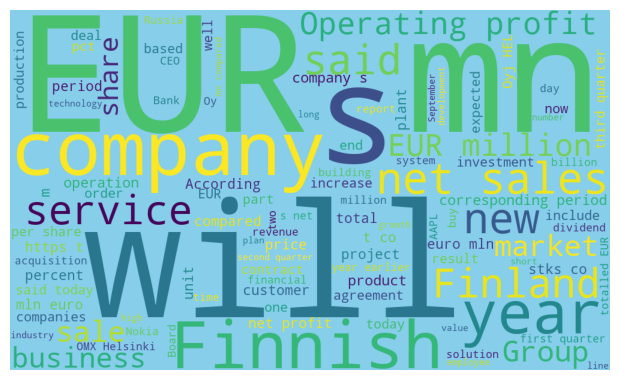

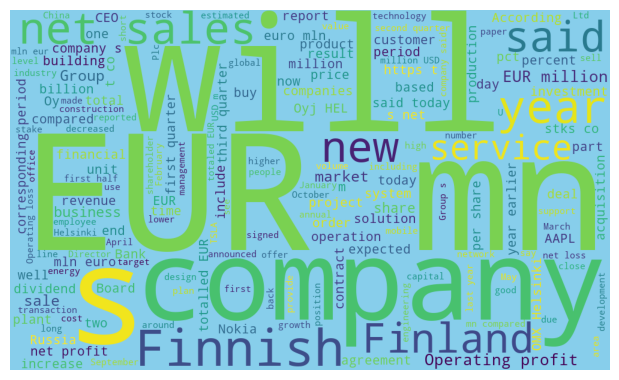

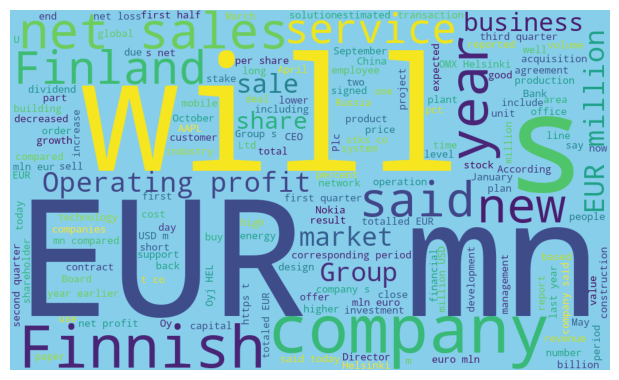

In [17]:
plot_negative, plot_neutral, plot_positive = vizualize_words_in_classes(data_raw)

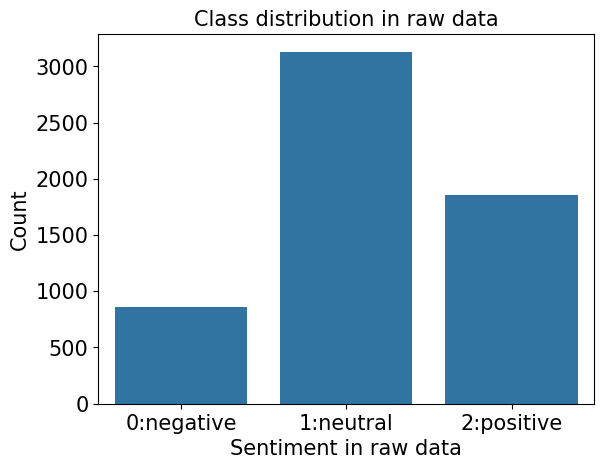

In [18]:
classes_in_raw_data = plot_class_distribution_in_raw_data(data_raw)

In [19]:
data_raw["Sentiment"].value_counts()

Sentiment
1    3130
2    1852
0     860
Name: count, dtype: int64

### 2.2. Sentiment "predicted" by TextBlob based on texts

TextBlob is a tool that already has a dictionary of words with their polarity (float number in range from -1 (negativie word) to 1 (positive word)). By using these numbers it can conclude about text polarity.

- How does the class distribution in sentiment calculated by TextBlob look like?
- How many texts are negative/neutral/positive?

In [20]:
def detect_sentiment(sentence: str) -> float:
    """
    Detects sentiment polarity between -1 and 1.
    :sentence: text to be analized
    :return: sentiment polarity
    """

    return TextBlob(sentence).sentiment.polarity

In [21]:
def analize_sentiment(sentiment: pd.DataFrame) -> int:
    """
    Detects sentiment: negative, neutral or positive.
    :sentiment: input dataframe
    :return: score 0 for negative, 1 for neutral and 2 for positive.
    """
    if sentiment < -1 / 3:
        score = 0
    elif -1 / 3 < sentiment < 1 / 3:
        score = 1
    else:
        score = 2

    return score

In [22]:
def calculate_sentiment_by_TextBlob(data_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Creates dataframe with sentiment calculation by TextBlob.
    :data_raw: dataframe with raw data
    :return: dataframe with raw data extended by sentiment calculation using TextBlob
    """
    sentiment_textblob = data_raw[["Sentence", "Sentiment"]]
    sentiment_textblob["SentimentAnalysis"] = sentiment_textblob["Sentence"].apply(
        detect_sentiment
    )
    sentiment_textblob["SentimentByTextblob"] = sentiment_textblob[
        "SentimentAnalysis"
    ].apply(analize_sentiment)

    return sentiment_textblob

In [23]:
def plot_class_distribution_TextBlob(sentiment_textblob: pd.DataFrame) -> plt:
    """
    Plots class distribution after calculating sentiment using TextBlob.
    :sentiment_textblob: dataframe with raw data extended by sentiment calculation using TextBlob
    :return: plot with class distribution in raw data
    """
    ax = sns.countplot(x="SentimentByTextblob", data=sentiment_textblob)
    ax.set_xticklabels(["0:negative", "1:neutral", "2:positive"])
    plt.xlabel("Sentiment by polarity", size=15)
    plt.xticklabels = ["0:negative", "1:neutral", "2:positive"]
    plt.xticks(fontsize=15)
    plt.ylabel("Count", size=15)
    plt.yticks(fontsize=15)
    plt.title("Class distribution by TextBlob", size=15)
    classes_textblob = plt

    return classes_textblob

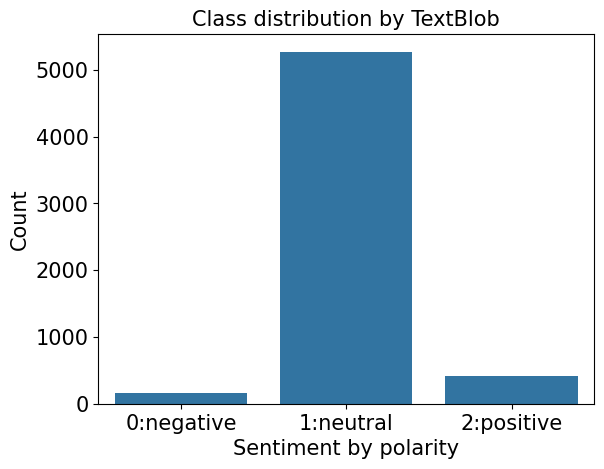

In [24]:
sentiment_textblob = calculate_sentiment_by_TextBlob(data_raw)
classes_textblob = plot_class_distribution_TextBlob(sentiment_textblob)

In [25]:
sentiment_textblob["SentimentByTextblob"].value_counts()

SentimentByTextblob
1    5273
2     414
0     155
Name: count, dtype: int64

## 3. Machine learning algorithms

We will compare two classificators:
- K-nearest-neighbors
- Neutral Network

### 3.1. Preparing train and test sets of the data

In [26]:
def prepare_xy(data_vectors: pd.DataFrame) -> (np.array, np.array):
    """
    Prepares the data: x,y.
    :data_vectors: dataframe with post-embedding data
    :return: x, y for building train, test data
    """
    x = data_vectors.iloc[:, :100].values
    y = data_vectors["Sentiment"]

    return x, y

In [27]:
def split_train_test(
    x: np.array, y: np.array
) -> (np.array, np.array, np.array, np.array):
    """
    Splits input dataset into train and test datasets.
    :x: x input values
    :y: y input values
    :return: arrays with train and test data
    """
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    return x_train, x_test, y_train, y_test

In [28]:
def prepare_train_test(data_vectors: pd.DataFrame) -> (np.array, np.array):
    """
    Prepares train and test numpy arrays from input dataframe.

    :data_vectors: dataframe with post-embedding data
    :return: arrays with train and test data
    """
    x, y = prepare_xy(data_vectors)
    x_train, x_test, y_train, y_test = split_train_test(x, y)

    return x_train, x_test, y_train, y_test

In [29]:
x_train, x_test, y_train, y_test = prepare_train_test(data_vectors)

### 3.2. Defining function that will evaluate our prediction (K-nearest-neighbors or neural network)

In [30]:
def evaluate_model(
    y_predicted: np.array, y_test: np.array
) -> (float, pd.DataFrame, plt):
    """
    Evaluates the model.
    Gives accuracy, classification report and plots confusion matrix.
    :y_predicted: predicted sentiment
    :y_test: y test data
    :return: accuracy score, classification report and confusion matrix
    """
    accuracy = np.round(accuracy_score(y_test, y_predicted), 2)
    report = classification_report(y_test, y_predicted, output_dict=True)
    report = pd.DataFrame(report).transpose().apply(lambda x: round(x, 2))
    report = report.drop(index="accuracy")
    confusion_matrix_plot = confusion_matrix(y_test, y_predicted)
    sns.heatmap(
        confusion_matrix_plot,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["0:negative", "1:neutral", "2:positive"],
        yticklabels=["0:negative", "1:neutral", "2:positive"],
    )
    plt.xlabel("Predicted labels", size=15)
    plt.xticks(fontsize=15)
    plt.ylabel("True labels", size=15)
    plt.yticks(fontsize=15)
    plt.title("Confusion Matrix", size=15)
    plot = plt

    return accuracy, report, plot

### 3.3. K-nearest neighbors model

- building the model
- training the model
- predicting sentiment by the model
- evaluating the model

#### Remeber: K-number of the neigbors should be an odd number

In [31]:
def build_k_nearest_neighbors_model() -> KNeighborsClassifier:
    """
    Builds k-nearest neighbors for n=5 (default) number of neighbors
    :return: k-nearest neighbors model
    """
    k_nearest_neighbors = KNeighborsClassifier(5)

    return k_nearest_neighbors

In [32]:
def train_k_nearest_neighbors_model(
    k_nearest_neighbors: KNeighborsClassifier, x_train: np.array, y_train: np.array
) -> np.array:
    """
    Trains k-nearest neighbors model.
    :k_nearest_neighbors: k-nearest neighbors model
    :x_train: x train data
    :y_train: y train data
    :return: trained k-nearest neighbors model
    """
    k_nearest_neighbors_trained = k_nearest_neighbors.fit(x_train, y_train)

    return k_nearest_neighbors_trained

In [33]:
def predict_k_nearest_neighbors(
    k_nearest_neighbors: KNeighborsClassifier, x_test: np.array
) -> np.array:
    """
    Predicts sentiment from k-nearest neighbors model.
    :k_nearest_neighbors: k-nearest neighbors model
    :return: prediction from k-nearest neighbors model
    """
    k_nearest_neighbors_prediction = k_nearest_neighbors.predict(x_test)

    return k_nearest_neighbors_prediction

In [34]:
def execute_k_nearest_neighbors(
    x_train: np.array, x_test: np.array, y_train: np.array, y_test: np.array
) -> (float, str, plt, np.array):
    """
    Exectutes k-nearest neighbors model.
    :x_train: x train data
    :y_train: y train data
    :x_test: x test data
    :y_test: y test data
    :return: accuracy score, classification report and confusion matrix
    """
    k_nearest_neighbors = build_k_nearest_neighbors_model()
    k_nearest_neighbors_trained = train_k_nearest_neighbors_model(
        k_nearest_neighbors, x_train, y_train
    )
    k_nearest_neighbors_prediction = predict_k_nearest_neighbors(
        k_nearest_neighbors, x_test
    )
    (
        accuracy_k_nearest_neighbors,
        report_k_nearest_neighbors,
        plot_k_nearest_neighbors,
    ) = evaluate_model(k_nearest_neighbors_prediction, y_test)

    return (
        accuracy_k_nearest_neighbors,
        report_k_nearest_neighbors,
        plot_k_nearest_neighbors,
        k_nearest_neighbors_prediction,
    )

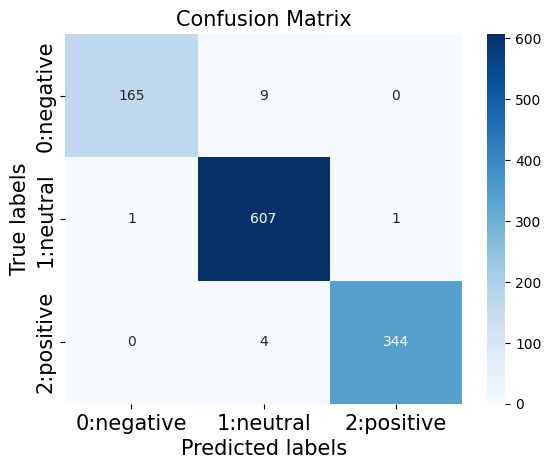

In [35]:
(
    accuracy_k_nearest_neighbors,
    report_k_nearest_neighbors,
    plot_k_nearest_neighbors,
    k_nearest_neighbors_prediction,
) = execute_k_nearest_neighbors(x_train, x_test, y_train, y_test)

In [36]:
print("Accuracy score for k-nearest neighbors model:")
print(accuracy_k_nearest_neighbors)
print("Classification report k-nearest neighbors model:")
print(report_k_nearest_neighbors)
plot_k_nearest_neighbors.show()

Accuracy score for k-nearest neighbors model:
0.99
Classification report k-nearest neighbors model:
              precision  recall  f1-score  support
0                  0.99    0.95      0.97    174.0
1                  0.98    1.00      0.99    609.0
2                  1.00    0.99      0.99    348.0
macro avg          0.99    0.98      0.98   1131.0
weighted avg       0.99    0.99      0.99   1131.0


### 3.4. Neural network model

- creating validation and test sets from previous test set 
- building the model
- training the model
- predicting sentiment by the model
- evaluating the model

In [37]:
def create_validation_set(
    x_test: np.array, y_test: np.array
) -> (np.array, np.array, np.array, np.array):
    """
    Splits test data into test and validation data.
    :x_test: x test data
    :y_test: y test data
    :return: original test data divided into new test data subset and validation data subset
    """
    x_test_subset, x_val, y_test_subset, y_val = train_test_split(
        x_test, y_test, test_size=0.5, random_state=42
    )

    return x_test_subset, x_val, y_test_subset, y_val

In [38]:
def build_neural_network_model(x_train: np.array) -> Type[Sequential]:
    """
    Bulids neural network sequential model.
    :x_train: x train data
    :return: neural network model
    """
    neural_network = Sequential()
    neural_network.add(Flatten())
    neural_network.add(Dense(128, activation="relu"))
    neural_network.add(Dense(32, activation="relu"))
    neural_network.add(Dense(3, activation="softmax"))
    neural_network.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return neural_network

In [39]:
def train_neural_network_model(
    neural_network: Type[Sequential],
    x_train: np.array,
    y_train: np.array,
    x_val: np.array,
    y_val: np.array,
) -> Type[History]:
    """
    Trains neural network model.
    :neural_network: neural network model
    :x_train: x train data
    :y_train: y train data
    :x_val: x validation data
    :y_val: y validation data
    :return: trained model
    """
    batch_size = 32
    early_stopping = EarlyStopping(monitor="val_loss", patience=10)
    neural_network_trained = neural_network.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=batch_size,
        verbose=True,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
    )

    return neural_network_trained

In [40]:
def predict_neural_network(
    neural_network: Type[Sequential], x_test_subset: np.array
) -> np.array:
    """
    Gives prediction from neural network model.
    :neural_network: neural network model
    :x_test_subset: x test subset
    :return: prediction from neural network model
    """
    y_pred_probs = neural_network.predict(x_test_subset)
    neural_network_prediction = np.argmax(y_pred_probs, axis=1)

    return neural_network_prediction

In [41]:
def execute_neural_network(
    x_train: np.array, x_test: np.array, y_train: np.array, y_test: np.array
) -> (float, str, plt, plt, Type[Sequential], np.array, np.array):
    """
    Exectutes neural network model.
    :x_train: x train data
    :y_train: y train data
    :x_test: x test data
    :y_test: y test data
    :return: accuracy score, classification report, confusion matrix, loss curve and neural network model
    """
    x_test_subset, x_val, y_test_subset, y_val = create_validation_set(x_test, y_test)
    neural_network = build_neural_network_model(x_train)
    neural_network_trained = train_neural_network_model(
        neural_network, x_train, y_train, x_val, y_val
    )
    neural_network_prediction = predict_neural_network(neural_network, x_test_subset)
    (
        accuracy_neural_network,
        report_neural_network,
        plot_neural_network,
    ) = evaluate_model(neural_network_prediction, y_test_subset)
    plt.figure()
    loss_curve_data = neural_network_trained.history["loss"]
    plt.plot(loss_curve_data)
    plt.xlabel("Epoch", size=15)
    plt.xticks(fontsize=15)
    plt.ylim(0, 1.1 * max(loss_curve_data))
    plt.ylabel("Loss", size=15)
    plt.yticks(fontsize=15)
    plt.title("Loss Curve", size=15)
    loss_curve = plt

    return (
        accuracy_neural_network,
        report_neural_network,
        plot_neural_network,
        loss_curve,
        neural_network,
        y_test_subset,
        neural_network_prediction,
    )

Epoch 1/100
142/142 [==============================] - 1s 3ms/step - loss: 0.4650 - accuracy: 0.8435 - val_loss: 0.0723 - val_accuracy: 0.9982
Epoch 2/100
142/142 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.9996 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 3/100
142/142 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 4/100
142/142 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 5/100
142/142 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/100
142/142 [==============================] - 0s 2ms/step - loss: 8.6617e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/100
142/142 [==============================] - 0s 2ms/step - loss: 5.9372e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy

142/142 [==============================] - 0s 2ms/step - loss: 1.2243e-06 - accuracy: 1.0000 - val_loss: 2.5180e-05 - val_accuracy: 1.0000
Epoch 56/100
142/142 [==============================] - 0s 2ms/step - loss: 1.1210e-06 - accuracy: 1.0000 - val_loss: 2.2831e-05 - val_accuracy: 1.0000
Epoch 57/100
142/142 [==============================] - 0s 2ms/step - loss: 1.0269e-06 - accuracy: 1.0000 - val_loss: 2.2269e-05 - val_accuracy: 1.0000
Epoch 58/100
142/142 [==============================] - 0s 2ms/step - loss: 9.3781e-07 - accuracy: 1.0000 - val_loss: 2.1446e-05 - val_accuracy: 1.0000
Epoch 59/100
142/142 [==============================] - 0s 2ms/step - loss: 8.6034e-07 - accuracy: 1.0000 - val_loss: 2.0642e-05 - val_accuracy: 1.0000
Epoch 60/100
142/142 [==============================] - 0s 2ms/step - loss: 7.8619e-07 - accuracy: 1.0000 - val_loss: 1.8260e-05 - val_accuracy: 1.0000
Epoch 61/100
142/142 [==============================] - 0s 2ms/step - loss: 7.2131e-07 - accuracy: 1.

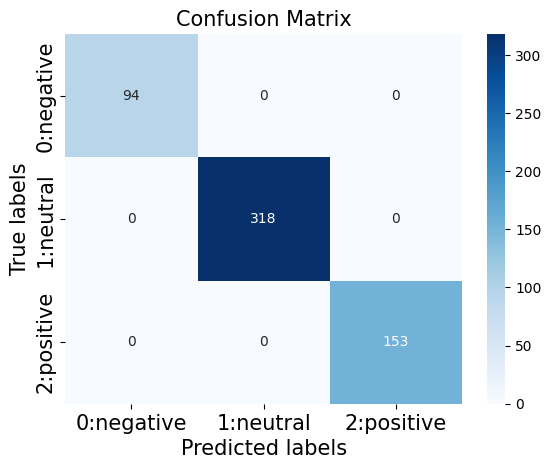

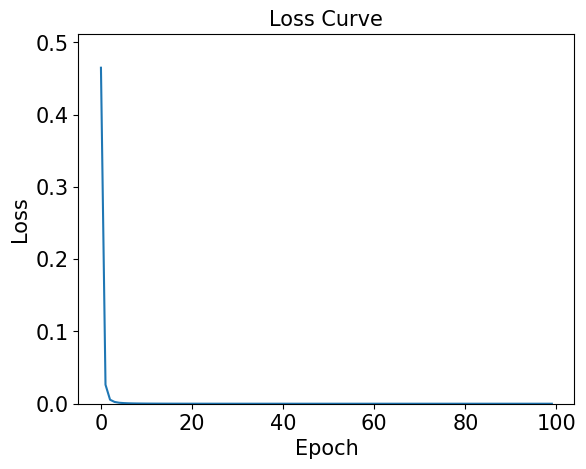

In [42]:
(
    accuracy_neural_network,
    report_neural_network,
    plot_neural_network,
    loss_curve,
    neural_network,
    y_test_subset,
    neural_network_prediction,
) = execute_neural_network(x_train, x_test, y_train, y_test)

In [43]:
neural_network.summary()
print("Accuracy score for neural network model:")
print(accuracy_neural_network)
print("Classification report for neural network model:")
print(report_neural_network)
plot_neural_network.show()
loss_curve.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 97)                0         
                                                                 
 dense (Dense)               (None, 128)               12544     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 16,771
Trainable params: 16,771
Non-trainable params: 0
_________________________________________________________________
Accuracy score for neural network model:
1.0
Classification report for neural network model:
              precision  recall  f1-score  support
0                   1.0     1.0       1.

### 3.5 Comparing K-nearest neighbors and neural network performance

In [44]:
def compare_models(
    accuracy_k_nearest_neighbors: float,
    report_k_nearest_neighbors: pd.DataFrame,
    accuracy_neural_network: float,
    report_neural_network: pd.DataFrame,
) -> pd.DataFrame:
    """
    Gives table with results for each model: precision, accuracy, recall and F1-score.
    :accuracy_k_nearest_neighbors: accuracy for k-nearest neighbors model
    :report_k_nearest_neighbors: classification report k-nearest neighbors model
    :accuracy_neural_network: accuracy for neural network model
    :report_neural_network: classification report neural network model
    :return: comparison of classification report for two models
    """
    result = pd.concat([report_k_nearest_neighbors, report_neural_network], axis=1)
    header = pd.MultiIndex.from_product(
        [
            [
                f"K-NN, Accuracy: {accuracy_k_nearest_neighbors}",
                f"NN, Accuracy: {accuracy_neural_network}",
            ],
            ["Precision", "Recall", "F-1 score", "Support"],
        ],
        names=["Model", "Metrics"],
    )
    result = pd.DataFrame(
        result.to_numpy(),
        index=["0", "1", "2", "macro avg", "weighted avg"],
        columns=header,
    )

    return result

In [45]:
print("Model comparison:")
result = compare_models(
    accuracy_k_nearest_neighbors,
    report_k_nearest_neighbors,
    accuracy_neural_network,
    report_neural_network,
)
result

Model comparison:


Model        K-NN, Accuracy: 0.99                          NN, Accuracy: 1.0  \
Metrics                 Precision Recall F-1 score Support         Precision   
0                            0.99   0.95      0.97   174.0               1.0   
1                            0.98   1.00      0.99   609.0               1.0   
2                            1.00   0.99      0.99   348.0               1.0   
macro avg                    0.99   0.98      0.98  1131.0               1.0   
weighted avg                 0.99   0.99      0.99  1131.0               1.0   

Model                                  
Metrics      Recall F-1 score Support  
0               1.0       1.0    94.0  
1               1.0       1.0   318.0  
2               1.0       1.0   153.0  
macro avg       1.0       1.0   565.0  
weighted avg    1.0       1.0   565.0

# **Homework questions**
 
### 1.	Most common words were visualized by the WordCloud using raw data. Perform the same visualization but for the text that has been cleaned (PreprocessedSentence). Do you see any difference?
### 2.	Show the class distribution for the test data. That is, how many texts are classified as neutral, how many as positive and how many as negative? Prepare a histogram to showcase those results. Note, that previously we've created such histogram for the whole dataset. Afterwards, show the distribution of predictions from the K-nearest neighbors and neural network model. Experiment with different input data. That is, experiment with using both spacy and word2vec embeddings. Are the distributions different? Are they skewed? If so, how?
### 3.	Choose a different classificator to solve our sentiment analysis problem. Build it and evaluate it. You can freely use the code provided in this notebook. 
### 4.	One of the most important metrics to evaluate the model is receiver operating characteristic curve (ROC curve) and area under the ROC curve (AUC). It is easy to plot it for binary classification – there is only one plot. Are there any ways to create such plots for the multiclassification problem?
### 5.	Compare the results from your model with K-nearest neighbors and neural network models. What are your conclusions? What can you do to improve any of these models, if the performance is not satisfying?
 
### Use data given in this course. Write your own code or modify the existing functions to accomplish the tasks. The example solution will be provided for the first two tasks, since the process of choosing the classificators and training them is already showcased in this notebook. 
 
### Good luck :)